In [1]:
# !pip install tensorflow
# !pip install keras
# !pip uninstall numpy --yes
# !pip install numpy --no-cache-dir

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import patheffects as path_effects
import six
from six.moves import zip  # pylint: disable=redefined-builtin
from six.moves import xrange  # pylint: disable=redefined-builtin

%matplotlib inline

/home/developer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Instatiate

In [4]:
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3)))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 64))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Preprocess

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    'assets/training_set',
    target_size = (64, 64),
    batch_size = 32,
    seed = 421,
    classes = ['micro', 'chest'],
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    'assets/testing_set',
    target_size = (64, 64),
    batch_size = 32,
    seed = 421,
    classes = ['micro', 'chest'],
    class_mode = 'binary')

Found 7902 images belonging to 2 classes.
Found 2196 images belonging to 2 classes.


### Build

In [6]:
batch_size = 15

classifier.fit_generator(
    train_generator,
    steps_per_epoch = 7902 // batch_size,
    epochs = 25,
    validation_data = test_generator,
    validation_steps = 2196 // batch_size)

Epoch 1/25
526/526 [==============================] - 101s 192ms/step - loss: 0.1225 - acc: 0.9706 - val_loss: 0.0202 - val_acc: 0.9940
Epoch 2/25
526/526 [==============================] - 98s 187ms/step - loss: 0.0509 - acc: 0.9902 - val_loss: 0.0117 - val_acc: 0.9978
Epoch 3/25
526/526 [==============================] - 100s 190ms/step - loss: 0.0369 - acc: 0.9910 - val_loss: 0.0225 - val_acc: 0.9951
Epoch 4/25
526/526 [==============================] - 108s 205ms/step - loss: 0.0328 - acc: 0.9910 - val_loss: 0.0372 - val_acc: 0.9944
Epoch 5/25
526/526 [==============================] - 99s 188ms/step - loss: 0.0487 - acc: 0.9906 - val_loss: 0.0140 - val_acc: 0.9974
Epoch 6/25
526/526 [==============================] - 103s 195ms/step - loss: 0.0295 - acc: 0.9929 - val_loss: 0.0247 - val_acc: 0.9963
Epoch 7/25
526/526 [==============================] - 99s 188ms/step - loss: 0.0366 - acc: 0.9920 - val_loss: 0.0135 - val_acc: 0.9976
Epoch 8/25
526/526 [==============================]

### Validate

In [7]:
validation_df = pd.DataFrame(columns = ['y_actual', 'y_pred'])
for which in ['micro', 'chest']:
    y_pred = []
    y_actual = []
    folder = 'other_assets/validation_set/{}'.format(which)
    for file in os.listdir(folder):
        filepath = os.path.join(folder, file)
        test_image = image.load_img(filepath, target_size = (64, 64))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = classifier.predict(test_image)
        if which == 'micro':
            if result[0][0] == 1:
                y_pred.append(1)     ## false positive
                y_actual.append(0)
            else:
                y_pred.append(0)     ## true negative
                y_actual.append(0)
        elif which == 'chest':
            if result[0][0] == 1:
                y_pred.append(1)     ## true positive
                y_actual.append(1)
            else:
                y_pred.append(0)     ## false negative
                y_actual.append(1)
    ys = pd.DataFrame(list(zip(y_actual, y_pred)), columns = ['y_actual', 'y_pred'])
    validation_df = pd.concat([validation_df, ys], axis = 0)

validation_df = validation_df.applymap(lambda x: int(x))

### Classification report & confusion matrix

In [8]:
cm = confusion_matrix(validation_df['y_actual'].values, validation_df['y_pred'].values)

In [9]:
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], \
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.grid(b = False)

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels, fontsize = 18)
    plt.yticks(tick_marks, labels, rotation = 90, fontsize = 18)

    plt.title(title, fontsize = 22)
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.tight_layout()

    width, height = cm.shape

    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=40).set_path_effects([path_effects.Stroke(linewidth=1, \
                            foreground='black'), path_effects.Normal()])
    return

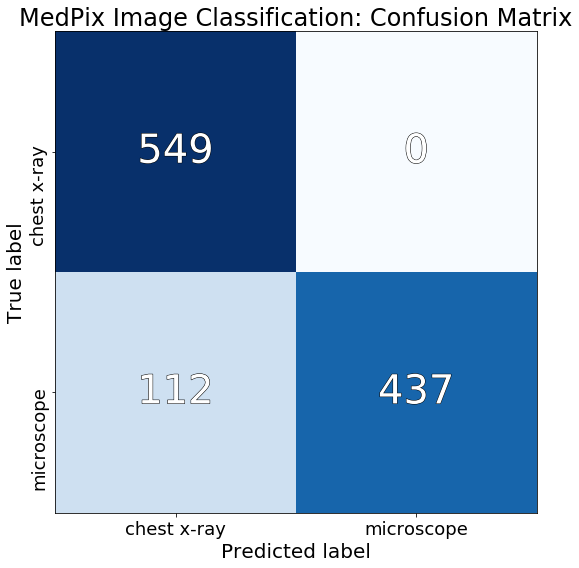

In [10]:
plot_confusion_matrix(
    cm,
    title = 'MedPix Image Classification: Confusion Matrix',
    labels = ['chest x-ray', 'microscope'])

In [11]:
print(classification_report(validation_df['y_actual'].values, validation_df['y_pred'].values))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91       549
          1       1.00      0.80      0.89       549

avg / total       0.92      0.90      0.90      1098



ta-da :wave: